In [11]:
#@title Import Dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import itertools
import pickle
import numpy as np
from numpy import random
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [13]:
from PIL import Image, ImageOps
from typing import TypeVar, Dict

from torch.optim.optimizer import Optimizer

Tensor = TypeVar('torch.tensor')


from argparse import Namespace
import ast
import os

import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
from typing import TypeVar, Tuple

import copy
import gc

In [14]:
img_size = 180
input_size = img_size*img_size*1 
batch_size = 200 # the size of input data took for one iteration

labels = ['PNEUMONIA', 'NORMAL']
transform_aug = transforms.Compose([transforms.RandomResizedCrop((img_size,img_size),antialias=True),transforms.RandomRotation(20), transforms.RandomHorizontalFlip(p=0.5), transforms.ToTensor()])
transform = transforms.Compose([transforms.Resize((img_size,img_size),antialias=True),transforms.ToTensor()])
def get_training_data_aug(data_dir,augment_ratio):
    data_list = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            for it in range(augment_ratio[class_num]):
                try:
                    img_arr = Image.open(os.path.join(path, img))
                    img_arr= ImageOps.grayscale(img_arr)
                    resized_arr = transform_aug(img_arr)
                    # Reshaping images to preferred size and grayscale transform
                    data_list.append([resized_arr,class_num])
                except Exception as e:
                    print(e)
    return data_list

def get_training_data(data_dir):
    data_list = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = Image.open(os.path.join(path, img))
                img_arr= ImageOps.grayscale(img_arr)
                resized_arr = transform(img_arr)
                # Reshaping images to preferred size and grayscale transform
                data_list.append([resized_arr,class_num])
            except Exception as e:
                print(e)
    return data_list

train_list = get_training_data_aug("./data/chest_xray/train",[3,9])
test_list = get_training_data("./data/chest_xray/test")
train_list=random.sample(train_list, len(train_list))
test_list=random.sample(test_list, len(test_list))
no_batches=len(train_list)//batch_size
test_no_batches=len(test_list)//batch_size
train_data_len=no_batches*batch_size
test_data_len=len(test_list)
test_data_len=test_no_batches*batch_size

KeyboardInterrupt: 

In [ ]:
def convert_to_image_list(data_list):
    images_list=[]
    labels_list=[]
    no_batches=len(data_list)//batch_size

    for i in range(no_batches):
        images_list.append(torch.zeros(batch_size,1,img_size,img_size).detach().cuda())
        labels= torch.zeros(batch_size)
        labels = labels.type(torch.LongTensor).cuda().detach()
        labels_list.append(labels)
        for it in range(batch_size):
            images_list[i][it,:,:,:]=data_list[i*batch_size+it][0]
            labels_list[i][it]=data_list[i*batch_size+it][1]
    return images_list,labels_list    

images_list, labels_list = convert_to_image_list(train_list)
del train_list
test_images_list, test_labels_list = convert_to_image_list(test_list)
del test_list
filepath="xray_data.pickle"
with open(filepath,"wb") as file:
    pickle.dump([images_list,labels_list,test_labels_list,test_images_list,no_batches,test_no_batches,batch_size,train_data_len,test_data_len],file)


In [ ]:

filepath="xray_data.pickle"
with open(filepath,"rb") as file:    
    [images_list,labels_list,test_labels_list,test_images_list,no_batches,test_no_batches,batch_size,train_data_len,test_data_len]=pickle.load(file)
    

In [ ]:
#@title Define model class
import torch.nn.functional as F

from typing import TypeVar, Tuple

Tensor = TypeVar('torch.tensor')

class NeuralNet(torch.nn.Module):
    """
    base class for all NN classifiers
    """
    def __init__(self):
        super().__init__()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

class chestxray_CNNnew(NeuralNet):

    def __init__(self,
                 flattened_size: int = 12544,
                 low_rank: int = 32,
                 batch_norm_mom: float = 1.0):
        """CNN Builder."""
        super(chestxray_CNNnew, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.Softplus(beta=1.0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
        # Second Convolutional Block
            nn.BatchNorm2d(32,momentum=batch_norm_mom),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.Softplus(beta=1.0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),        
        # Third Convolutional Block
            nn.BatchNorm2d(64,momentum=batch_norm_mom),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.Softplus(beta=1.0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
        
        # Fourth Convolutional Block
            nn.BatchNorm2d(64,momentum=batch_norm_mom),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Softplus(beta=1.0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),      
        # Fifth Convolutional Block
            nn.BatchNorm2d(128,momentum=batch_norm_mom),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.Softplus(beta=1.0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
        )

        self.fc_layer = nn.Sequential(
            nn.BatchNorm1d(flattened_size,momentum=batch_norm_mom),
            nn.Linear(flattened_size, low_rank),
            nn.BatchNorm1d(low_rank,momentum=batch_norm_mom),
            nn.Linear(low_rank, 512),            
            nn.Softplus(beta=1.0), 
            nn.BatchNorm1d(512,momentum=batch_norm_mom),
        )

        self.last_layer=nn.Sequential(
            nn.Linear(512, 2)
        )

    def forward(self, x: Tensor) -> Tensor:
        """Perform forward."""

        # conv layers
        x = self.conv_layer(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)

        x=self.last_layer(x)

        return x

    def classify(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
        net_out = self.forward(x)
        acc = F.softmax(net_out, dim=1)
        class_idx = torch.max(net_out, 1)[1]

        return acc, acc[0, class_idx], class_idx
    


class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [5]:
#@title Define loss-function & optimizer
loss_function = nn.CrossEntropyLoss()


def images_regulariser(net): 
    li_reg_loss = 0
    penalized     = [p for name,p in net.named_parameters() if 'bias' not in name]
    not_penalized = [p for name,p in net.named_parameters() if 'bias' in name]
    for p in penalized:
        li_reg_loss += (p**2).sum()*0.5
    #for p in net.parameters():
#        li_reg_loss += (p**2).sum()*0.5
    reg=li_reg_loss/(train_data_len)*l2regconst
    return(reg)


In [6]:
def addnet(net,net2):
    for param1, param2 in zip(net.parameters(), net2.parameters()):
     param1.data += param2.data

def multiplynet(net,a):
   for param1 in net.parameters():
     param1.data *=a

In [ ]:
from dataclasses import dataclass
@dataclass
class hclass:
    h: Tensor
    eta: Tensor
    etam1g: Tensor
    c11: Tensor
    c21: Tensor
    c22: Tensor

def hper2const(h,gam):
    gh=gam.double()*h.double()
    s=torch.sqrt(4*torch.expm1(-gh/2)-torch.expm1(-gh)+gh)
    eta=(torch.exp(-gh/2)).float()
    etam1g=((-torch.expm1(-gh/2))/gam.double()).float()
    c11=(s/gam).float()
    c21=(torch.exp(-gh)*(torch.expm1(gh/2.0))**2/s).float()
    c22=(torch.sqrt(8*torch.expm1(-gh/2)-4*torch.expm1(-gh)-gh*torch.expm1(-gh))/s).float()
    hc=hclass(h=h,eta=eta,etam1g=etam1g,c11=c11,c21=c21,c22=c22)
    return(hc)

def U(x,v,hc):
    xi1=torch.randn(x.size(),device=device)
    xi2=torch.randn(x.size(),device=device)

    xn=x+hc.etam1g*v+hc.c11*xi1
    vn=v*hc.eta+hc.c21*xi1+hc.c22*xi2
    return([xn, vn])

def bounce(x,v,xstar,width):
    vsign=(((x-xstar+width)/(2*width)).floor()% 2)*(-2)+1
    vn=v*vsign
    xn=((x-xstar-width)% (4*width)-2*width).abs()-width+xstar
    # num_outside=((xn-xstar)>width).sum()+((xstar-xn)>width).sum()
    # if(num_outside>0):
    #     print(num_outside)    
    return([xn, vn])

def bouncenet(net):
    for p,p_star in zip(net.parameters(),net_star.parameters()):
        [p.data, p.v]=bounce(p.data, p.v, p_star.data, 6/torch.sqrt(l2regconst_extra))

def UBU_step(net,hper2c,images,labels,batch_it):   
    with torch.no_grad():
        for p in list(net.parameters()):

            [p.data,p.v]=U(p.data,p.v,hper2c)

        bouncenet(net)

    outputsU = net(images)
    loss_likelihood = loss_function(outputsU, labels)  


    grads_reg=[torch.zeros_like(par) for par in net.parameters()]
    net_pars=list(net.parameters())
    with torch.no_grad():
        for it in range(len_params):
            if(list_no_bias[it]):
                grads_reg[it]=net_pars[it].data*l2regconst

    net.zero_grad()
    #loss.backward()
    loss_likelihood.backward()
    with torch.no_grad():
        grads_likelihood=[par.grad*batch_size for par in net.parameters()]
    
        #Normal, no variance reduction
        # for p,p_star in zip(net.parameters(),net_star.parameters()):      
        #     p.v-=hper2c.h*(p.grad*train_data_len+l2regconst_extra*(p.data-p_star.data))

        for p,grad,grad_reg,p_star,grad_star,star_sum_grad in zip(list(net.parameters()),grads_likelihood,grads_reg,list(net_star.parameters()),net_star_grad_list[batch_it],net_star_full_grad):              
            #Using variance reduction
            p.v-=hper2c.h*(grad_reg+star_sum_grad+(grad-grad_star)*no_batches+l2regconst_extra*(p.data-p_star.data))

        for p in list(net.parameters()):
            [p.data,p.v]=U(p.data,p.v,hper2c)

    #bouncenet()
    return(loss_likelihood.data)

def ind_create(batch_it):
    modit=batch_it %(2*no_batches)
    ind=(modit<=(no_batches-1))*modit+(modit>=no_batches)*(2*no_batches-modit-1)
    return ind

In [ ]:
#@title Output arrays
par_runs=64
num_classes=2
num_epochs=60
switch_to_sampling_epoch=20
switch_to_swa_epoch=15


num_swa_epochs=switch_to_sampling_epoch-switch_to_swa_epoch

training_size=no_batches*batch_size
test_size=test_data_len
labels_arr=torch.zeros(training_size)
test_labels_arr=torch.zeros(test_size)
test_prob_arr=torch.zeros([test_size,num_classes,num_epochs,par_runs])

lr = 1e-2
lr_swa=1e-3
h=5e-4
l2regconst=torch.tensor(1).detach()
l2regconst_extra=torch.tensor(50).detach()
gam=torch.sqrt(l2regconst_extra)
hper2c=hper2const(torch.tensor(h/2),gam)

for par_it in range(par_runs):
  print("par_it:",par_it,"\n")
  #@title Build the model
  net = chestxray_CNNnew().cuda()
  net.train()
  optimizer = torch.optim.Adam( net.parameters(), lr=lr)
  
  lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer=optimizer, total_iters=switch_to_swa_epoch,power=1)


  #@title Training the model

  for epoch in range(num_epochs):
    sum_loss=0
    #l2regconst=torch.min(torch.tensor(1+epoch),torch.tensor(switch_to_swa_epoch)).detach()
    # if(epoch<switch_to_sampling_epoch):
    net.train()
    if(epoch==(switch_to_swa_epoch-1)):
      net2=copy.deepcopy(net)
      multiplynet(net2,0)
      optimizer=torch.optim.Adam(net.parameters(),lr=lr_swa)

    if(epoch>=switch_to_sampling_epoch and (epoch-switch_to_sampling_epoch)%2==0):
        rperm=random.permutation(list(range(no_batches)))
    
    for i in range(no_batches): 
      if(epoch<switch_to_sampling_epoch):
        b=torch.randint(high=no_batches,size=(1,1))
      else:
        it=(epoch-switch_to_sampling_epoch)*no_batches+i
        b=rperm[ind_create(it)]
        
      images=images_list[b]
      labels=labels_list[b]
      
      # outputs = net(images)    
      # loss = loss_function(outputs, labels)
      # sum_loss=sum_loss+loss    
      # reg=images_regulariser()
      # loss=loss+reg
      # optimizer.zero_grad()
      # loss.backward()
      # optimizer.step()
      # sum_loss_tot=sum_loss_tot+loss

      if(epoch<switch_to_sampling_epoch):
        outputs = net(images)    
        loss_likelihood = loss_function(outputs, labels)
        sum_loss=sum_loss+loss_likelihood    
        reg=images_regulariser(net)
        loss=loss_likelihood+reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(epoch>=(switch_to_swa_epoch)):
          addnet(net2,net)
      else:
        loss_likelihood=UBU_step(net,hper2c,images,labels,b)
        sum_loss=sum_loss+loss_likelihood




    #if (i+1) % (no_batches) == 0:
    #print("Reg:",reg)
    print('Epoch [%d/%d], Step [%d/%d]' %(epoch+1, num_epochs, i+1, no_batches))
    correct = 0
    total = 0
    





    if epoch==(switch_to_sampling_epoch-1):
      multiplynet(net2,1/(num_swa_epochs*no_batches))
      multiplynet(net,0)
      addnet(net,net2)
      del net2
      gc.collect()

      len_params=len(list(net.parameters()))
      net_star=copy.deepcopy(net)

      #Variance reduction - saving gradients at each batch at x_star
      net_star_grad_list=[]
      net_star_full_grad=[torch.zeros_like(par, device=device) for par in list(net.parameters())]
      for i in range(no_batches):
          images=images_list[i]
          labels=labels_list[i]
          outputs=net(images)
          loss_likelihood = loss_function(outputs, labels)
          reg=images_regulariser(net)
          net.zero_grad()
          loss_likelihood.backward()
          with torch.no_grad():
            grads=[par.grad*batch_size for par in list(net.parameters())]
            net_star_grad_list.append(grads)
            for g, gi in zip(net_star_full_grad,grads):
              g+=gi
                      
      len_params=len(list(net.parameters()))
      list_no_bias=torch.zeros(len_params)
      pit=0
      for name, p in net_star.named_parameters():
          if 'bias' not in name:
              list_no_bias[pit]=1.0
          pit+=1

      #Initialise velocities
      for par in list(net.parameters()):
        par.v = torch.randn_like(par,device=device).detach()      
    with torch.no_grad():
      net(torch.cat(images_list[0:20],dim=0).detach())
      net.eval()
      for testit in range(test_no_batches):
        imagest=test_images_list[testit]
        labelst=test_labels_list[testit]
        actual_batch_size=len(imagest)
        test_labels_arr[(testit*batch_size):(testit*batch_size+actual_batch_size)]=labelst.detach().cpu()
        outputt = net(imagest).detach()#.reshape(actual_batch_size).detach()
        _, predictedt = torch.max(outputt,1)

        correct += (predictedt == labelst).sum()
        total += labelst.size(0)

        test_prob_arr[(testit*batch_size):(testit*batch_size+actual_batch_size),:,epoch,par_it]=torch.softmax(outputt,dim=1)
    

    print('Test accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

    if(epoch<=switch_to_swa_epoch):
      lr_scheduler.step()
    print('Epoch [%d], Average Loss: %0.4f' %(epoch+1, sum_loss/no_batches))
  
  
  filepath="output_chest_xray_rand6.pickle"
  with open(filepath,"wb") as file:
    pickle.dump([labels_arr.numpy(),test_labels_arr.numpy(),test_prob_arr.numpy()],file)

par_it: 0 



KeyboardInterrupt: 

In [10]:
# net_star.eval()
# len_params=len(list(net_star.parameters()))
# list_no_bias=torch.zeros(len_params)
# it=0
# for name, p in net_star.named_parameters():
#     if 'bias' not in name:
#         list_no_bias[it]=1.0
#     it+=1

# def hess_vec(vec):   
#     out=net_star(images)
#     loss=loss_function(out,labels)*train_data_len
#     net_star.zero_grad()
#     grad=list(torch.autograd.grad(loss,list(net_star.parameters()),create_graph=True))
#     res=torch.zeros(1).cuda()
#     for it in range(len_params):
#         res+=(grad[it]*vec[it]).sum()

#     net_star.zero_grad()
#     hvp=list(torch.autograd.grad(res,list(net_star.parameters()),create_graph=False))

#     with torch.no_grad():
#         for it in range(len_params):
#             if(list_no_bias[it]):
#                 hvp[it]+=vec[it]*l2regconst
#     return(hvp)
    
# def hess_vec_full(vec):
#     hvfull=copy.deepcopy(list(vec))
#     for p in hvfull:
#         p.requires_grad=False
#         p*=0
#     len_pars=len(hvfull)
#     for it in range(no_batches):
#         images=images_list[it]
#         labels=labels_list[it]
#         hv=hess_vec(vec)
#         for pit in range(len_pars):
#             hvfull[pit]+=hv[pit]
#     return(hvfull)

# def norm_par(vec):
#     n=torch.zeros(1).detach().cuda()
#     for p in vec:
#         n+=p.pow(2).sum()
#     return n.sqrt()

# def multiply_par(vec,c):
#     res_vec=copy.deepcopy(vec)
#     for it in range(len_params):
#         res_vec[it].requires_grad=False
#         res_vec[it]=res_vec[it]*c
#     return res_vec

# def scalar_prod_par(vec1,vec2):
#     res=torch.zeros(1).cuda()
#     for it in range(len_params):
#         res+=(vec1[it]*vec2[it]).sum()
#     return res

# def add_par(vec1,vec2):
#     res_vec=copy.deepcopy(vec1)
#     for it in range(len_params):
#         res_vec[it].requires_grad=False
#         res_vec[it]=vec1[it]+vec2[it]
#     return res_vec


# vec=copy.deepcopy(list(net_star.parameters()))
# for p in vec:
#     p.requires_grad=False
# norm_iter=norm_par(vec)
# vec=multiply_par(vec,torch.Tensor(1/norm_iter))
# for iter in range(10):
#     vec=hess_vec_full(vec)
#     norm_iter=norm_par(vec)
#     vec=multiply_par(vec,1/norm_iter)    
#     print(norm_iter)

# max_eigen_vec=copy.deepcopy(vec)
# max_eigen=norm_iter



In [11]:
#filepath="output_fashion.pickle"
#with open(filepath,"rb") as file:
#    [labels_arr,test_labels_arr,test_prob_arr,_,_]=pickle.load(file)
#labels_arr=torch.tensor(labels_arr).detach()
#test_labels_arr=torch.tensor(test_labels_arr).detach()
#test_prob_arr=torch.tensor(test_prob_arr).detach()

In [30]:
def rps_single(probs, true_label,num_classes):
    outcome=torch.zeros(num_classes)
    outcome[true_label.int()]=1.0
    cum_probs = torch.cumsum(probs,0)
    cum_outcomes = torch.cumsum(outcome,0)
    
    sum_rps = 0
    for i in range(len(outcome)):         
        sum_rps+= (cum_probs[i] - cum_outcomes[i])**2
    
    return sum_rps/(num_classes-1)

def rps_calc(test_probs, true_labels,test_data_len,num_classes):
    rps_vec=torch.zeros(test_data_len)
    for it in range(test_data_len):
        rps_vec[it]=rps_single(test_probs[it,:].reshape(num_classes),true_labels[it],num_classes)
    return rps_vec

def nll_calc(test_probs, true_labels,test_data_len,num_classes):
    res=0
    for it in range(test_data_len):
        res-=torch.max(torch.tensor([torch.log(test_probs[it,true_labels[it].int()]),-100]))
    return res/test_data_len


def adaptive_calibration_error(test_probs,true_labels, test_data_len, num_classes,num_bins=20):
    o=torch.tensor(0.0).detach()
    for k in range(num_classes):
        ind=torch.argsort(test_probs[:,k],stable=True)        
        testprobsk=test_probs[:,k]
        sorted_probs=testprobsk[ind]
        sorted_true_labels=true_labels[ind]

        true_label_is_k = (sorted_true_labels==k).clone().detach().float()
        bins=(torch.tensor(range(test_data_len))/torch.tensor(test_data_len/num_bins)).floor()

        for b in range(num_bins):
            mask = (bins == b)
            if torch.any(mask):
                o += (true_label_is_k[mask] - sorted_probs[mask]).mean().abs()

    return o / (num_bins*num_classes)


def compute_acc_ace_rps_no_bayes(es,par_runs,switch_to_swa_epoch,test_data_len,num_classes,test_prob_arr,test_labels_arr):
    copies=int(par_runs/es)
    ace_arr=torch.zeros(copies)
    rps_arr=torch.zeros(copies)
    nll_arr=torch.zeros(copies)
    accuracy_arr=torch.zeros(copies)

    for it in range(copies):
        test_prob=torch.Tensor(test_prob_arr[:,:,switch_to_swa_epoch-1,it*es:(it+1)*es]).mean(-1).reshape(test_data_len,num_classes)
        ace_arr[it]=adaptive_calibration_error(test_prob,test_labels_arr,test_data_len, num_classes)
        rps_arr[it]=(rps_calc(test_prob, test_labels_arr,test_data_len,num_classes)).mean()
        nll_arr[it]=nll_calc(test_prob, test_labels_arr,test_data_len,num_classes)
        _, predictedt = torch.max(test_prob,1)
        accuracy_arr[it]= (predictedt==test_labels_arr.reshape(1,test_data_len)).sum()/test_data_len
    print("Non-Bayesian, ensemble size:", es)
    print("mean accuracy:",accuracy_arr.mean(),"std:",accuracy_arr.std())
    print("mean ace:",ace_arr.mean(),"std:",ace_arr.std())
    print("mean nll:",nll_arr.mean(),"std:",nll_arr.std())
    print("mean rps:",rps_arr.mean(),"std:",rps_arr.std())
    return [accuracy_arr.mean(),accuracy_arr.std(),ace_arr.mean(),ace_arr.std(),rps_arr.mean(),rps_arr.std(),nll_arr.mean(),nll_arr.std()]

def compute_acc_ace_rps_swa(es,par_runs,switch_to_sampling_epoch,test_data_len,num_classes,test_prob_arr,test_labels_arr):
    copies=int(par_runs/es)
    ace_arr=torch.zeros(copies)
    rps_arr=torch.zeros(copies)
    nll_arr=torch.zeros(copies)
    accuracy_arr=torch.zeros(copies)

    for it in range(copies):
        test_prob=torch.Tensor(test_prob_arr[:,:,switch_to_sampling_epoch-1,it*es:(it+1)*es]).mean(-1).reshape(test_data_len,num_classes)
        ace_arr[it]=adaptive_calibration_error(test_prob,test_labels_arr,test_data_len, num_classes)
        rps_arr[it]=(rps_calc(test_prob, test_labels_arr,test_data_len,num_classes)).mean()
        nll_arr[it]=nll_calc(test_prob, test_labels_arr,test_data_len,num_classes)
        _, predictedt = torch.max(test_prob,1)
        accuracy_arr[it]= (predictedt==test_labels_arr.reshape(1,test_data_len)).sum()/test_data_len
    print("SWA, ensemble size:", es)
    print("mean accuracy:",accuracy_arr.mean(),"std:",accuracy_arr.std())
    print("mean ace:",ace_arr.mean(),"std:",ace_arr.std())
    print("mean nll:",nll_arr.mean(),"std:",nll_arr.std())
    print("mean rps:",rps_arr.mean(),"std:",rps_arr.std())
    return [accuracy_arr.mean(),accuracy_arr.std(),ace_arr.mean(),ace_arr.std(),rps_arr.mean(),rps_arr.std(),nll_arr.mean(),nll_arr.std()]

#Bayesian
def compute_acc_ace_rps_bayes(es,par_runs,switch_to_sampling_epoch,burnin_epochs,num_epochs,test_data_len,num_classes,test_prob_arr,test_labels_arr): 
    copies=int(par_runs/es)
    ace_arr=torch.zeros(copies)
    rps_arr=torch.zeros(copies)
    nll_arr=torch.zeros(copies)
    accuracy_arr=torch.zeros(copies)

    for it in range(copies):
        test_prob=torch.Tensor(test_prob_arr[:,:,(switch_to_sampling_epoch+burnin_epochs):num_epochs,it*es:(it+1)*es]).mean(-1).mean(-1).reshape(test_data_len,num_classes)
        ace_arr[it]=adaptive_calibration_error(test_prob,test_labels_arr,test_data_len, num_classes)
        rps_arr[it]=(rps_calc(test_prob, test_labels_arr,test_data_len,num_classes)).mean()
        nll_arr[it]=nll_calc(test_prob, test_labels_arr,test_data_len,num_classes)
        _, predictedt = torch.max(test_prob,1)
        accuracy_arr[it]= (predictedt==test_labels_arr.reshape(1,test_data_len)).sum()/test_data_len
    print("Bayesian, ensemble size:", es)
    print("mean accuracy:",accuracy_arr.mean(),"std:",accuracy_arr.std())
    print("mean ace:",ace_arr.mean(),"std:",ace_arr.std())
    print("mean nll:",nll_arr.mean(),"std:",nll_arr.std())
    print("mean rps:",rps_arr.mean(),"std:",rps_arr.std())
    return [accuracy_arr.mean(),accuracy_arr.std(),ace_arr.mean(),ace_arr.std(),rps_arr.mean(),rps_arr.std(),nll_arr.mean(),nll_arr.std()]


In [31]:
#no bayesian
acc,acc_std,ace,ace_std,rps,rps_std,nll,nll_std=(torch.zeros(5),torch.zeros(5),
torch.zeros(5),torch.zeros(5),torch.zeros(5),torch.zeros(5),torch.zeros(5),torch.zeros(5))
for it in range(5):
     [acc[it],acc_std[it],ace[it],ace_std[it],rps[it],rps_std[0],nll[it],nll_std[it]]=\
     compute_acc_ace_rps_no_bayes(pow(2,it),par_runs,switch_to_swa_epoch,test_data_len,num_classes,test_prob_arr,test_labels_arr)


from scipy.io import savemat
filepath="results_xray_no_bayes_SMS_UBU.mat"
mdic={"acc":acc.cpu().numpy(),"acc_std":acc_std.cpu().numpy(),"nll": nll.cpu().numpy(),"nll_std":nll_std.cpu().numpy(),\
     "ace": ace.cpu().numpy(),"ace_std":ace_std.cpu().numpy(), "rps":rps.cpu().numpy(),"rps_std":rps_std.cpu().numpy()}
savemat(filepath,mdic)

Non-Bayesian, ensemble size: 1
mean accuracy: tensor(0.7272) std: tensor(0.1355)
mean ace: tensor(0.3506) std: tensor(0.2081)
mean nll: tensor(65.7856) std: tensor(47.6477)
mean rps: tensor(1.0955) std: tensor(0.7443)
Non-Bayesian, ensemble size: 2
mean accuracy: tensor(0.7318) std: tensor(0.1431)
mean ace: tensor(0.3439) std: tensor(0.2192)
mean nll: tensor(65.7296) std: tensor(48.1091)
mean rps: tensor(1.0907) std: tensor(0.7571)
Non-Bayesian, ensemble size: 4
mean accuracy: tensor(0.7430) std: tensor(0.1507)
mean ace: tensor(0.3391) std: tensor(0.2208)
mean nll: tensor(62.6355) std: tensor(49.8196)
mean rps: tensor(1.0629) std: tensor(0.7615)
Non-Bayesian, ensemble size: 8
mean accuracy: tensor(0.7456) std: tensor(0.1596)
mean ace: tensor(0.3356) std: tensor(0.2290)
mean nll: tensor(62.6157) std: tensor(51.5953)
mean rps: tensor(1.0494) std: tensor(0.8018)
Non-Bayesian, ensemble size: 16
mean accuracy: tensor(0.7833) std: tensor(0.1771)
mean ace: tensor(0.3343) std: tensor(0.2248)
m

In [13]:
# def GRdiagnostics(res):
#   J=res.shape[0] #Number of chains
#   L=res.shape[1] #Number of samples after burnin
#   res_means=res.mean(dim=1)
#   res_mean=res_means.mean()
#   B=(res_means-res_mean).pow(2).sum()*L/(J-1)
#   W=(res_means.reshape([J,1])@torch.ones([1,L])-res).pow(2).sum()/(J*(L-1))
#   R=(W*(L-1)/L+B/L)/W
#   return R


# par_chains=4
# no_GR_epochs=60
# test_prob_GR_arr=torch.zeros([test_size,num_classes])
# nll_GR_arr=torch.zeros([par_chains,no_GR_epochs])
# for chain in range(par_chains):
#     net=copy.deepcopy(net_star)
#     net.eval()
#     for par in list(net.parameters()):
#       par.v = torch.randn_like(par,device=device)          
#     for epoch in range(no_GR_epochs):
#       print("chain: ",chain, "/epoch:",epoch)
#       if(epoch % 2 == 1):
#         irange=range(no_batches-1,-1,-1)
#       else:
#         irange=range(no_batches)
#       for b in irange:
#         images=images_list[b]
#         labels=labels_list[b]
#         UBU_step(hper2c,images,labels,b)

#       for testit in range(test_no_batches):
#         imagest=test_images_list[testit]
#         labelst=test_labels_list[testit]
#         actual_batch_size=len(imagest)
#         outputt = net(imagest).detach()
#         test_prob_GR_arr[(testit*batch_size):(testit*batch_size+actual_batch_size),:]=torch.softmax(outputt,dim=1)
      
#       nll_GR_arr[chain,epoch]=nll_calc(test_prob_GR_arr,test_labels_arr)
#       print("NLL:", nll_GR_arr[chain,epoch])

# print(GRdiagnostics(nll_GR_arr))

In [14]:
#test_prob=torch.Tensor(test_prob_arr[:,:,29,0]).reshape(test_size,num_classes)
#torch.cumsum(test_prob[1,:].reshape(num_classes),0)
#rps_single(test_prob[1,:].reshape(num_classes),test_labels_arr[1])


In [21]:
#no bayesian
def compute_acc_ace_rps_no_bayes(es):
    copies=int(64/es)
    ace_arr=torch.zeros(copies)
    rps_arr=torch.zeros(copies)
    nll_arr=torch.zeros(copies)
    accuracy_arr=torch.zeros(copies)

    for it in range(copies):
        test_prob=torch.Tensor(test_prob_arr[:,:,14,it*es:(it+1)*es]).mean(-1).reshape(test_size,num_classes)
        ace_arr[it]=adaptive_calibration_error(test_prob,test_labels_arr)
        rps_arr[it]=(rps_calc(test_prob, test_labels_arr)).mean()
        nll_arr[it]=nll_calc(test_prob, test_labels_arr)
        _, predictedt = torch.max(test_prob,1)
        accuracy_arr[it]= (predictedt==test_labels_arr.reshape(1,test_size)).sum()/test_size
    print("Non-Bayesian, ensemble size:", es)
    print("mean accuracy:",accuracy_arr.mean(),"std:",accuracy_arr.std())
    print("mean ace:",ace_arr.mean(),"std:",ace_arr.std())
    print("mean nll:",nll_arr.mean(),"std:",nll_arr.std())
    print("mean rps:",rps_arr.mean(),"std:",rps_arr.std())
    return [accuracy_arr.mean(),accuracy_arr.std(),ace_arr.mean(),ace_arr.std(),rps_arr.mean(),rps_arr.std(),nll_arr.mean(),nll_arr.std()]

acc=torch.zeros(5)
acc_std=torch.zeros(5)
ace=torch.zeros(5)
ace_std=torch.zeros(5)
rps=torch.zeros(5)
rps_std=torch.zeros(5)
nll=torch.zeros(5)
nll_std=torch.zeros(5)
[acc[0],acc_std[0],ace[0],ace_std[0],rps[0],rps_std[0],nll[0],nll_std[0]]=compute_acc_ace_rps_no_bayes(1)
[acc[1],acc_std[1],ace[1],ace_std[1],rps[1],rps_std[1],nll[1],nll_std[1]]=compute_acc_ace_rps_no_bayes(2)
[acc[2],acc_std[2],ace[2],ace_std[2],rps[2],rps_std[2],nll[2],nll_std[2]]=compute_acc_ace_rps_no_bayes(4)
[acc[3],acc_std[3],ace[3],ace_std[3],rps[3],rps_std[3],nll[3],nll_std[3]]=compute_acc_ace_rps_no_bayes(8)
[acc[4],acc_std[4],ace[4],ace_std[4],rps[4],rps_std[4],nll[4],nll_std[4]]=compute_acc_ace_rps_no_bayes(16)

from scipy.io import savemat
filepath="results_xray_no_bayes_rand.mat"
mdic={"acc":acc.cpu().numpy(),"acc_std":acc_std.cpu().numpy(),"nll": nll.cpu().numpy(),"nll_std":nll_std.cpu().numpy(),\
      "ace": ace.cpu().numpy(),"ace_std":ace_std.cpu().numpy(), "rps":rps.cpu().numpy(),"rps_std":rps_std.cpu().numpy()}
savemat(filepath,mdic)

Non-Bayesian, ensemble size: 1
mean accuracy: tensor(0.9133) std: tensor(0.0109)
mean ace: tensor(0.0679) std: tensor(0.0102)
mean nll: tensor(0.5280) std: tensor(0.0888)
mean rps: tensor(0.0760) std: tensor(0.0095)
Non-Bayesian, ensemble size: 2
mean accuracy: tensor(0.9259) std: tensor(0.0062)
mean ace: tensor(0.0452) std: tensor(0.0071)
mean nll: tensor(0.3366) std: tensor(0.0473)
mean rps: tensor(0.0623) std: tensor(0.0048)
Non-Bayesian, ensemble size: 4
mean accuracy: tensor(0.9313) std: tensor(0.0050)
mean ace: tensor(0.0311) std: tensor(0.0062)
mean nll: tensor(0.2587) std: tensor(0.0339)
mean rps: tensor(0.0554) std: tensor(0.0036)
Non-Bayesian, ensemble size: 8
mean accuracy: tensor(0.9329) std: tensor(0.0042)
mean ace: tensor(0.0275) std: tensor(0.0044)
mean nll: tensor(0.2142) std: tensor(0.0110)
mean rps: tensor(0.0517) std: tensor(0.0026)
Non-Bayesian, ensemble size: 16
mean accuracy: tensor(0.9362) std: tensor(0.0050)
mean ace: tensor(0.0196) std: tensor(0.0023)
mean nll:

Non-Bayesian, ensemble size: 1
mean accuracy: tensor(0.9296) std: tensor(0.0020)
mean ace: tensor(0.0555) std: tensor(0.0018)
mean nll: tensor(0.4709) std: tensor(0.0251)
mean rps: tensor(0.0230) std: tensor(0.0008)
Non-Bayesian, ensemble size: 2
mean accuracy: tensor(0.9383) std: tensor(0.0015)
mean ace: tensor(0.0294) std: tensor(0.0016)
mean nll: tensor(0.3109) std: tensor(0.0127)
mean rps: tensor(0.0188) std: tensor(0.0005)
Non-Bayesian, ensemble size: 4
mean accuracy: tensor(0.9422) std: tensor(0.0010)
mean ace: tensor(0.0177) std: tensor(0.0011)
mean nll: tensor(0.2385) std: tensor(0.0066)
mean rps: tensor(0.0168) std: tensor(0.0003)
Non-Bayesian, ensemble size: 8
mean accuracy: tensor(0.9443) std: tensor(0.0006)
mean ace: tensor(0.0126) std: tensor(0.0007)
mean nll: tensor(0.2025) std: tensor(0.0042)
mean rps: tensor(0.0157) std: tensor(0.0002)
Non-Bayesian, ensemble size: 16
mean accuracy: tensor(0.9459) std: tensor(0.0009)
mean ace: tensor(0.0098) std: tensor(0.0007)
mean nll: tensor(0.1832) std: tensor(0.0029)
mean rps: tensor(0.0152) std: tensor(8.2395e-05)

In [22]:
#swa
def compute_acc_ace_rps_swa(es):
    copies=int(64/es)
    ace_arr=torch.zeros(copies)
    rps_arr=torch.zeros(copies)
    nll_arr=torch.zeros(copies)
    accuracy_arr=torch.zeros(copies)

    for it in range(copies):
        test_prob=torch.Tensor(test_prob_arr[:,:,19,it*es:(it+1)*es]).mean(-1).reshape(test_size,num_classes)
        ace_arr[it]=adaptive_calibration_error(test_prob,test_labels_arr)
        rps_arr[it]=(rps_calc(test_prob, test_labels_arr)).mean()
        nll_arr[it]=nll_calc(test_prob, test_labels_arr)
        _, predictedt = torch.max(test_prob,1)
        accuracy_arr[it]= (predictedt==test_labels_arr.reshape(1,test_size)).sum()/test_size
    print("SWA, ensemble size:", es)
    print("mean accuracy:",accuracy_arr.mean(),"std:",accuracy_arr.std())
    print("mean ace:",ace_arr.mean(),"std:",ace_arr.std())
    print("mean nll:",nll_arr.mean(),"std:",nll_arr.std())
    print("mean rps:",rps_arr.mean(),"std:",rps_arr.std())
    return [accuracy_arr.mean(),accuracy_arr.std(),ace_arr.mean(),ace_arr.std(),rps_arr.mean(),rps_arr.std(),nll_arr.mean(),nll_arr.std()]

acc=torch.zeros(5)
acc_std=torch.zeros(5)
ace=torch.zeros(5)
ace_std=torch.zeros(5)
rps=torch.zeros(5)
rps_std=torch.zeros(5)
nll=torch.zeros(5)
nll_std=torch.zeros(5)
[acc[0],acc_std[0],ace[0],ace_std[0],rps[0],rps_std[0],nll[0],nll_std[0]]=compute_acc_ace_rps_swa(1)
[acc[1],acc_std[1],ace[1],ace_std[1],rps[1],rps_std[1],nll[1],nll_std[1]]=compute_acc_ace_rps_swa(2)
[acc[2],acc_std[2],ace[2],ace_std[2],rps[2],rps_std[2],nll[2],nll_std[2]]=compute_acc_ace_rps_swa(4)
[acc[3],acc_std[3],ace[3],ace_std[3],rps[3],rps_std[3],nll[3],nll_std[3]]=compute_acc_ace_rps_swa(8)
[acc[4],acc_std[4],ace[4],ace_std[4],rps[4],rps_std[4],nll[4],nll_std[4]]=compute_acc_ace_rps_swa(16)

from scipy.io import savemat
filepath="results_xray_swa_rand.mat"
mdic={"acc":acc.cpu().numpy(),"acc_std":acc_std.cpu().numpy(),"nll": nll.cpu().numpy(),"nll_std":nll_std.cpu().numpy(),\
      "ace": ace.cpu().numpy(),"ace_std":ace_std.cpu().numpy(), "rps":rps.cpu().numpy(),"rps_std":rps_std.cpu().numpy()}
savemat(filepath,mdic)

SWA, ensemble size: 1
mean accuracy: tensor(0.9183) std: tensor(0.0099)
mean ace: tensor(0.0668) std: tensor(0.0087)
mean nll: tensor(0.5719) std: tensor(0.0703)
mean rps: tensor(0.0732) std: tensor(0.0080)
SWA, ensemble size: 2
mean accuracy: tensor(0.9273) std: tensor(0.0055)
mean ace: tensor(0.0442) std: tensor(0.0065)
mean nll: tensor(0.3751) std: tensor(0.0406)
mean rps: tensor(0.0609) std: tensor(0.0040)
SWA, ensemble size: 4
mean accuracy: tensor(0.9320) std: tensor(0.0036)
mean ace: tensor(0.0344) std: tensor(0.0059)
mean nll: tensor(0.2823) std: tensor(0.0230)
mean rps: tensor(0.0545) std: tensor(0.0025)
SWA, ensemble size: 8
mean accuracy: tensor(0.9360) std: tensor(0.0023)
mean ace: tensor(0.0263) std: tensor(0.0029)
mean nll: tensor(0.2306) std: tensor(0.0088)
mean rps: tensor(0.0512) std: tensor(0.0017)
SWA, ensemble size: 16
mean accuracy: tensor(0.9371) std: tensor(0.0039)
mean ace: tensor(0.0222) std: tensor(0.0037)
mean nll: tensor(0.2002) std: tensor(0.0165)
mean rps:

SWA, ensemble size: 1
mean accuracy: tensor(0.9337) std: tensor(0.0016)
mean ace: tensor(0.0537) std: tensor(0.0016)
mean nll: tensor(0.4826) std: tensor(0.0191)
mean rps: tensor(0.0220) std: tensor(0.0006)
SWA, ensemble size: 2
mean accuracy: tensor(0.9403) std: tensor(0.0012)
mean ace: tensor(0.0309) std: tensor(0.0012)
mean nll: tensor(0.3312) std: tensor(0.0111)
mean rps: tensor(0.0184) std: tensor(0.0004)
SWA, ensemble size: 4
mean accuracy: tensor(0.9435) std: tensor(0.0011)
mean ace: tensor(0.0223) std: tensor(0.0010)
mean nll: tensor(0.2579) std: tensor(0.0078)
mean rps: tensor(0.0166) std: tensor(0.0003)
SWA, ensemble size: 8
mean accuracy: tensor(0.9453) std: tensor(0.0008)
mean ace: tensor(0.0180) std: tensor(0.0011)
mean nll: tensor(0.2186) std: tensor(0.0036)
mean rps: tensor(0.0157) std: tensor(0.0002)
SWA, ensemble size: 16
mean accuracy: tensor(0.9462) std: tensor(0.0008)
mean ace: tensor(0.0158) std: tensor(0.0009)
mean nll: tensor(0.1964) std: tensor(0.0034)
mean rps: tensor(0.0153) std: tensor(5.5335e-05)

In [23]:
#Bayesian
def compute_acc_ace_rps_bayes(es):
    copies=int(64/es)
    ace_arr=torch.zeros(copies)
    rps_arr=torch.zeros(copies)
    nll_arr=torch.zeros(copies)
    accuracy_arr=torch.zeros(copies)

    for it in range(copies):
        test_prob=torch.Tensor(test_prob_arr[:,:,30:60,it*es:(it+1)*es]).mean(-1).mean(-1).reshape(test_size,num_classes)
        ace_arr[it]=adaptive_calibration_error(test_prob,test_labels_arr)
        rps_arr[it]=(rps_calc(test_prob, test_labels_arr)).mean()
        nll_arr[it]=nll_calc(test_prob, test_labels_arr)
        _, predictedt = torch.max(test_prob,1)
        accuracy_arr[it]= (predictedt==test_labels_arr.reshape(1,test_size)).sum()/test_size
    print("Bayesian, ensemble size:", es)
    print("mean accuracy:",accuracy_arr.mean(),"std:",accuracy_arr.std())
    print("mean ace:",ace_arr.mean(),"std:",ace_arr.std())
    print("mean nll:",nll_arr.mean(),"std:",nll_arr.std())
    print("mean rps:",rps_arr.mean(),"std:",rps_arr.std())
    return [accuracy_arr.mean(),accuracy_arr.std(),ace_arr.mean(),ace_arr.std(),rps_arr.mean(),rps_arr.std(),nll_arr.mean(),nll_arr.std()]



acc=torch.zeros(5)
acc_std=torch.zeros(5)
ace=torch.zeros(5)
ace_std=torch.zeros(5)
rps=torch.zeros(5)
rps_std=torch.zeros(5)
nll=torch.zeros(5)
nll_std=torch.zeros(5)
[acc[0],acc_std[0],ace[0],ace_std[0],rps[0],rps_std[0],nll[0],nll_std[0]]=compute_acc_ace_rps_bayes(1)
[acc[1],acc_std[1],ace[1],ace_std[1],rps[1],rps_std[1],nll[1],nll_std[1]]=compute_acc_ace_rps_bayes(2)
[acc[2],acc_std[2],ace[2],ace_std[2],rps[2],rps_std[2],nll[2],nll_std[2]]=compute_acc_ace_rps_bayes(4)
[acc[3],acc_std[3],ace[3],ace_std[3],rps[3],rps_std[3],nll[3],nll_std[3]]=compute_acc_ace_rps_bayes(8)
[acc[4],acc_std[4],ace[4],ace_std[4],rps[4],rps_std[4],nll[4],nll_std[4]]=compute_acc_ace_rps_bayes(16)

from scipy.io import savemat
filepath="results_xray_bayes_rand.mat"
mdic={"acc":acc.cpu().numpy(),"acc_std":acc_std.cpu().numpy(),"nll": nll.cpu().numpy(),"nll_std":nll_std.cpu().numpy(),\
      "ace": ace.cpu().numpy(),"ace_std":ace_std.cpu().numpy(), "rps":rps.cpu().numpy(),"rps_std":rps_std.cpu().numpy()}
savemat(filepath,mdic)

Bayesian, ensemble size: 1
mean accuracy: tensor(0.9239) std: tensor(0.0072)
mean ace: tensor(0.0322) std: tensor(0.0061)
mean nll: tensor(0.2354) std: tensor(0.0231)
mean rps: tensor(0.0599) std: tensor(0.0046)
Bayesian, ensemble size: 2
mean accuracy: tensor(0.9301) std: tensor(0.0049)
mean ace: tensor(0.0275) std: tensor(0.0049)
mean nll: tensor(0.2045) std: tensor(0.0158)
mean rps: tensor(0.0551) std: tensor(0.0027)
Bayesian, ensemble size: 4
mean accuracy: tensor(0.9341) std: tensor(0.0045)
mean ace: tensor(0.0245) std: tensor(0.0048)
mean nll: tensor(0.1896) std: tensor(0.0077)
mean rps: tensor(0.0528) std: tensor(0.0018)
Bayesian, ensemble size: 8
mean accuracy: tensor(0.9350) std: tensor(0.0040)
mean ace: tensor(0.0224) std: tensor(0.0034)
mean nll: tensor(0.1821) std: tensor(0.0063)
mean rps: tensor(0.0515) std: tensor(0.0012)
Bayesian, ensemble size: 16
mean accuracy: tensor(0.9358) std: tensor(0.0035)
mean ace: tensor(0.0219) std: tensor(0.0047)
mean nll: tensor(0.1788) std:

Bayesian, ensemble size: 1
mean accuracy: tensor(0.9355) std: tensor(0.0016)
mean ace: tensor(0.0195) std: tensor(0.0028)
mean nll: tensor(0.2348) std: tensor(0.0133)
mean rps: tensor(0.0181) std: tensor(0.0004)
Bayesian, ensemble size: 2
mean accuracy: tensor(0.9410) std: tensor(0.0014)
mean ace: tensor(0.0085) std: tensor(0.0016)
mean nll: tensor(0.1917) std: tensor(0.0048)
mean rps: tensor(0.0165) std: tensor(0.0003)
Bayesian, ensemble size: 4
mean accuracy: tensor(0.9439) std: tensor(0.0011)
mean ace: tensor(0.0051) std: tensor(0.0011)
mean nll: tensor(0.1724) std: tensor(0.0031)
mean rps: tensor(0.0157) std: tensor(0.0002)
Bayesian, ensemble size: 8
mean accuracy: tensor(0.9452) std: tensor(0.0006)
mean ace: tensor(0.0046) std: tensor(0.0007)
mean nll: tensor(0.1632) std: tensor(0.0014)
mean rps: tensor(0.0153) std: tensor(6.1413e-05)
Bayesian, ensemble size: 16
mean accuracy: tensor(0.9462) std: tensor(0.0005)
mean ace: tensor(0.0044) std: tensor(0.0006)
mean nll: tensor(0.1582) std: tensor(0.0005)
mean rps: tensor(0.0151) std: tensor(3.4585e-05)

In [18]:
# test_prob=torch.Tensor(test_prob_arr[:,7,0]).reshape(test_size,1)
# ace=adaptive_calibration_error(test_labels_arr.reshape(test_size,1).numpy(),test_prob.numpy(),20)
# ace

In [19]:
# test_prob=torch.Tensor(test_prob_arr[:,10:16,48:64]).mean(-1).mean(-1).reshape(test_size,1)
# ace=adaptive_calibration_error(test_labels_arr.reshape(test_size,1).numpy(),test_prob.numpy(),20)
# ace

In [20]:
n=0
for par in net2.parameters():
    n+=par.numel()
n

NameError: name 'net2' is not defined

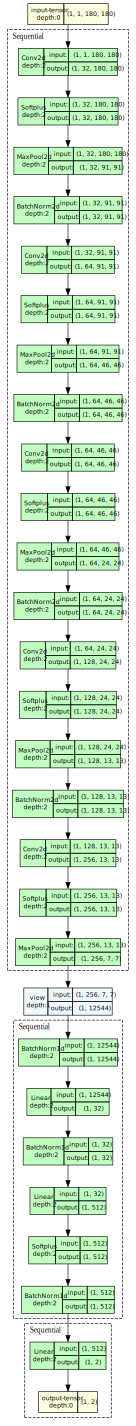

In [2]:
import torchvision
from torchview import draw_graph
net2 = chestxray_CNNnew()

#model_graph = draw_graph(net2, input_size=(1,3,64,64), expand_nested=True)
model_graph = draw_graph(net2, input_size=(1,1,180,180), expand_nested=True)
model_graph.visual_graph
